# Recognising water potability


By: Karin Falconer-Bailey


#### Table of contents
* [Chapter 1: Importing functions](#Functions)
* [Chapter 2: Data preparation](#chapter02)
    * [2.1. Missing values](#section_2_1)
* [Chapter 3: Data derivation](#chapter03)
    * [3.1 Renaming columns](#section_3_1)
    * [3.2 Detecting outliers](#section_3_2)
* [Chapter 4: Modelling the data](#chapter04)
    * [4.1 EDA](#section_4_1)
        * [4.1.1. Central tendencies](#section_4_1_1)
        * [4.1.2. Correlation plot](#section_4_1_2)
        * [4.1.3. 5 rows](#section_4_1_3)
        * [4.1.4. Sampling the data](#section_4_1_4)
    * [4.2 Model construction](#section_4_2)
        * [4.2.1. Shuffling the data](#section_4_2_1)
        * [4.2.2. Predictor and response](#section_4_2_2)
        * [4.2.3. Test and train split](#section_4_2_3)
        * [4.2.4. Feature scaling](#section_4_2_4)
        * [4.2.5. SMOTE](#section_4_2_5)
* [Chapter 5: Building a MLP](#chapter05)
    * [5.1 Layers and Parameters](#section_5_1)
    * [5.2 Training results](#section_5_2)
    * [5.3 Hyperparameter tuning](#section_5_2)
* [Chapter 6: Building a SVM](#chapter06)
    * [6.1 Parameters](#section_6_1)
    * [6.2 Training results](#section_6_2)
    * [6.3 Hyperparameter tuning](#section_6_2)
* [Chapter 7: Final models](#chapter07)    
    * [7.1 MLP](#section_7_1)
    * [7.2 SVM](#section_7_2)
    * [7.3 Confusion matrix](#section_7_2)

### Chapter 1: Importing functions <a class="anchor" id="Functions"></a>

Importing the necessary Python functions

In [86]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# scipy functions
import scipy
from scipy import stats
from scipy.stats import pearsonr
import statsmodels.api as sm

# sklearn functions
import sklearn as sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.svm import SVC

# torch functions
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = 'cpu'

# skorch function
import skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping

# smote functions
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE

import math

from platform import python_version

import warnings
warnings.filterwarnings('ignore')

print the versions of the code's packages 

In [87]:
# Reference: https://www.codegrepper.com/code-examples/python/check+package+version+python
# Necessary packages

print('Python: ', python_version())
print('Sklearn:', sklearn.__version__)
print('Seaborn:', sns.__version__)
print('Scipy:', scipy.__version__)
print('Torch:', torch.__version__)
print('Skorch:', skorch.__version__)

Python:  3.8.8
Sklearn: 0.24.1
Seaborn: 0.11.1
Scipy: 1.6.2
Torch: 1.11.0
Skorch: 0.11.0


### Chapter 2: Data preparation <a class="anchor" id="chapter02"></a>


First we open the file, and save it as its own dataframe

In [88]:
file = open('water_quality.csv')
waterquality = pd.read_csv('water_quality.csv')

Here, I display the dataframe to show the contents of the file.

In [89]:
waterquality 

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681736,47580.99160,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.80216,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.57822,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.86938,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


### 2.1. Missing values <a class="anchor" id="section_2_1"></a>

Now, we check the dataframe of missing values.

In [90]:
waterquality.isna().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

Replace missing values with the corresponding column's mean

In [91]:
waterquality['ph'] = waterquality['ph'].fillna(waterquality['ph'].mean())
waterquality['Sulfate'] = waterquality['Sulfate'].fillna(waterquality['Sulfate'].mean())
waterquality['Trihalomethanes'] = waterquality['Trihalomethanes'].fillna(waterquality['Trihalomethanes'].mean())


waterquality

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.080795,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,333.775777,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,333.775777,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681736,47580.99160,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.80216,8.061362,333.775777,392.449580,19.903225,66.396293,2.798243,1
3273,9.419510,175.762646,33155.57822,7.350233,333.775777,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.86938,6.303357,333.775777,402.883113,11.168946,77.488213,4.708658,1


Ensure missing data has been filled

In [92]:
waterquality.isna().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

### Chapter 3: Data derivation <a class="anchor" id="chapter03"></a>

#### 3.1. Renaming columns <a class="anchor" id="section_3_1"></a>


Rename certain columns

In [93]:
waterquality.rename(columns = {'ph':'pH','Hardness':'Hardness','Solids':'Solids',
                         'Chloramines':'Chloramines','Sulfate':'Sulfates','Conductivity':'Conductivity',
                         'Organic_carbon':'Organic_carbon','Trihalomethanes':'Trihalomethanes','Turbidity':'Turbidity'
                               ,'Potability':'Potability'}, inplace = True)

Call the dataframe to ensure columns have been renamed

In [94]:
# Reference: https://wwww.geeksforgeeks.org/how-to-get-column-names-in-pandas-dataframe/amp/

for col in waterquality.columns:
    print(col)

pH
Hardness
Solids
Chloramines
Sulfates
Conductivity
Organic_carbon
Trihalomethanes
Turbidity
Potability


#### 3.2. Detecting outliers <a class="anchor" id="section_3_2"></a>

Create histograms for all features within the data to check for their distribution.

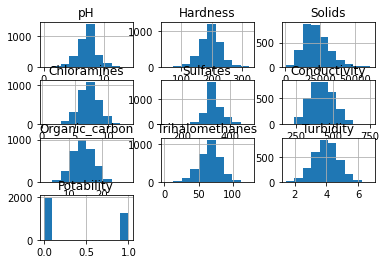

<Figure size 432x288 with 0 Axes>

In [95]:
waterquality.hist()
plt.show()
plt.savefig('variabledistributions.jpeg') # Reference: https://www.tutorialspoint.com/save-figure-as-file-from-ipython-notebook-using-matplotlib

H0: The feature has a normal distribution

HA: The feature does not have a normal distribution

a = 0.05

In [96]:
print(stats.jarque_bera(waterquality['pH']))
print(stats.jarque_bera(waterquality['Hardness']))
print(stats.jarque_bera(waterquality['Solids']))
print(stats.jarque_bera(waterquality['Chloramines']))
print(stats.jarque_bera(waterquality['Sulfates']))
print(stats.jarque_bera(waterquality['Conductivity']))
print(stats.jarque_bera(waterquality['Organic_carbon']))
print(stats.jarque_bera(waterquality['Trihalomethanes']))
print(stats.jarque_bera(waterquality['Turbidity']))
print(stats.jarque_bera(waterquality['Potability']))

Jarque_beraResult(statistic=257.42661280993593, pvalue=0.0)
Jarque_beraResult(statistic=52.13699758884013, pvalue=4.770850381419223e-12)
Jarque_beraResult(statistic=237.26207610380845, pvalue=0.0)
Jarque_beraResult(statistic=47.14080495718171, pvalue=5.801015223738659e-11)
Jarque_beraResult(statistic=436.0413610591753, pvalue=0.0)
Jarque_beraResult(statistic=48.747825344325726, pvalue=2.5974333794920312e-11)
Jarque_beraResult(statistic=0.6022947173534984, pvalue=0.7399687239002685)
Jarque_beraResult(statistic=26.306933943475485, pvalue=1.9387502921963673e-06)
Jarque_beraResult(statistic=0.6018342386167425, pvalue=0.7401391134463167)
Jarque_beraResult(statistic=551.6261325743462, pvalue=0.0)


Based on the results we reject the null hypothesis for the following columns:

    Hardness, Chloramines, Conductivity, Organic_carbon, Trihalomethanes, Turbidity

Create a boxplot for the distributions of Hardness, Chloramines, Conductivity, Organic_carbon, Trihalomethanes, and Turbidity

0.25    176.850538
0.50    196.967627
0.75    216.667456
Name: Hardness, dtype: float64


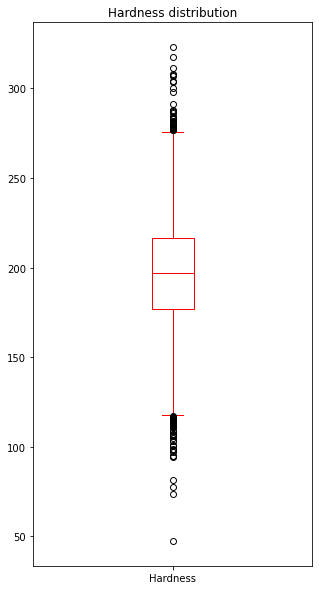

In [97]:
print(waterquality['Hardness'].quantile([0.25, 0.5, 0.75]))
waterquality['Hardness'].plot(kind='box', title='Hardness distribution',color='r', figsize=(5,10))
plt.show()

0.25    6.127421
0.50    7.130299
0.75    8.114887
Name: Chloramines, dtype: float64


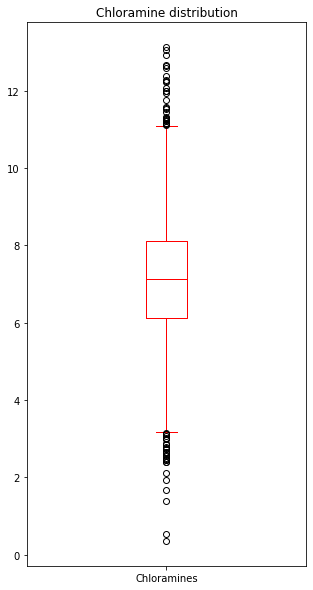

In [98]:
print(waterquality['Chloramines'].quantile([0.25, 0.5, 0.75]))
waterquality['Chloramines'].plot(kind='box', title='Chloramine distribution',color='r', figsize=(5,10))
plt.show()

0.25    365.734414
0.50    421.884968
0.75    481.792305
Name: Conductivity, dtype: float64


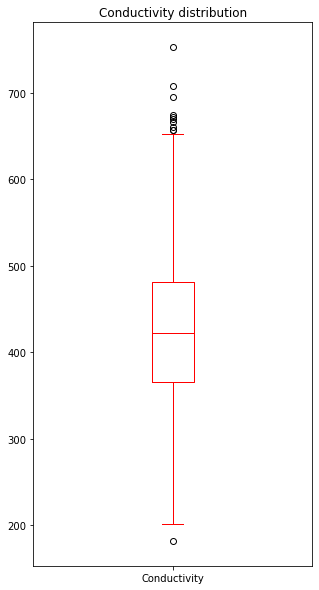

In [99]:
print(waterquality['Conductivity'].quantile([0.25, 0.5, 0.75]))
waterquality['Conductivity'].plot(kind='box', title='Conductivity distribution',color='r', figsize=(5,10))
plt.show()

0.25    12.065801
0.50    14.218338
0.75    16.557652
Name: Organic_carbon, dtype: float64


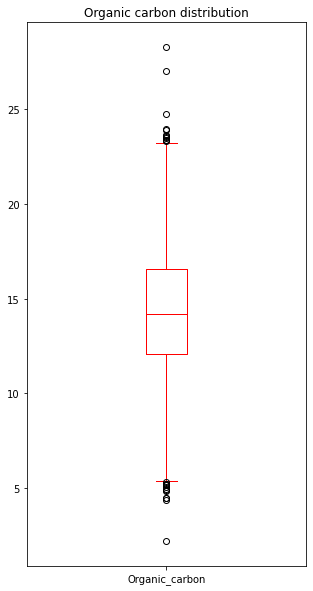

In [100]:
print(waterquality['Organic_carbon'].quantile([0.25, 0.5, 0.75]))
waterquality['Organic_carbon'].plot(kind='box', title='Organic carbon distribution',color='r', figsize=(5,10))
plt.show()

0.25    56.647656
0.50    66.396293
0.75    76.666609
Name: Trihalomethanes, dtype: float64


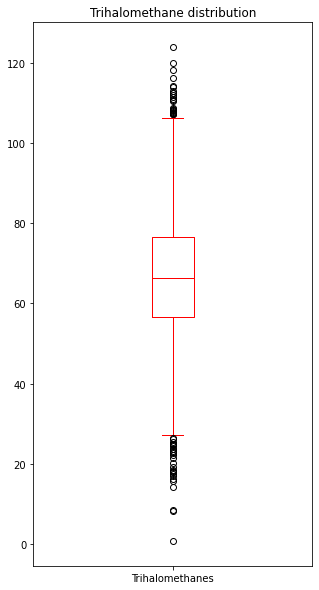

In [101]:
print(waterquality['Trihalomethanes'].quantile([0.25, 0.5, 0.75]))
waterquality['Trihalomethanes'].plot(kind='box', title='Trihalomethane distribution',color='r', figsize=(5,10))
plt.show()

0.25    3.439711
0.50    3.955028
0.75    4.500320
Name: Turbidity, dtype: float64


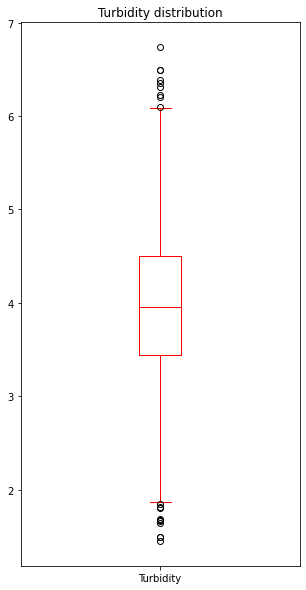

In [102]:
print(waterquality['Turbidity'].quantile([0.25, 0.5, 0.75]))
waterquality['Turbidity'].plot(kind='box', title='Turbidity distribution',color='r', figsize=(5,10))
plt.show()

Convert the outliers for all above variables into NaN values

In [103]:
# Reference : https://www.journaldev.com/51466/python-catboost-classifier-module

for x in ['Hardness']:
    q85,q15 = np.percentile(waterquality.loc[:,x],[85,15])
    intr_qr = q85-q15
    maximum = q85+(1.5*intr_qr)
    minimum = q15-(1.5*intr_qr)
    waterquality.loc[waterquality[x] < minimum,x] = np.nan
    waterquality.loc[waterquality[x] > maximum,x] = np.nan
    
for x in ['Chloramines']:
    q85,q15 = np.percentile(waterquality.loc[:,x],[85,15])
    intr_qr = q85-q15
    maximum = q85+(1.5*intr_qr)
    minimum = q15-(1.5*intr_qr)
    waterquality.loc[waterquality[x] < minimum,x] = np.nan
    waterquality.loc[waterquality[x] > maximum,x] = np.nan
       
for x in ['Conductivity']:
    q85,q15 = np.percentile(waterquality.loc[:,x],[85,15])
    intr_qr = q85-q15
    maximum = q85+(1.5*intr_qr)
    minimum = q15-(1.5*intr_qr)
    waterquality.loc[waterquality[x] < minimum,x] = np.nan
    waterquality.loc[waterquality[x] > maximum,x] = np.nan

for x in ['Organic_carbon']:
    q85,q15 = np.percentile(waterquality.loc[:,x],[85,15])
    intr_qr = q85-q15
    maximum = q85+(1.5*intr_qr)
    minimum = q15-(1.5*intr_qr)
    waterquality.loc[waterquality[x] < minimum,x] = np.nan
    waterquality.loc[waterquality[x] > maximum,x] = np.nan
    
for x in ['Trihalomethanes']:
    q85,q15 = np.percentile(waterquality.loc[:,x],[85,15])
    intr_qr = q85-q15
    maximum = q85+(1.5*intr_qr)
    minimum = q15-(1.5*intr_qr)
    waterquality.loc[waterquality[x] < minimum,x] = np.nan
    waterquality.loc[waterquality[x] > maximum,x] = np.nan
    
for x in ['Turbidity']:
    q85,q15 = np.percentile(waterquality.loc[:,x],[85,15])
    intr_qr = q85-q15
    maximum = q85+(1.5*intr_qr)
    minimum = q15-(1.5*intr_qr)
    waterquality.loc[waterquality[x] < minimum,x] = np.nan
    waterquality.loc[waterquality[x] > maximum,x] = np.nan

Since we have converted the outliers into NaN values, this will have to be dealt with as previously done before.

Again we check, this time just to ensure we do have NaN values present.

In [104]:
waterquality.isna().sum()

pH                 0
Hardness           1
Solids             0
Chloramines        2
Sulfates           0
Conductivity       0
Organic_carbon     1
Trihalomethanes    1
Turbidity          0
Potability         0
dtype: int64

Replace the NaN values with the corresponding column's mean.

Call for the display of NaN values to ensure the dataframe has been cleaned.

In [105]:
waterquality['Hardness'] = waterquality['Hardness'].fillna(waterquality['Hardness'].mean())
waterquality['Chloramines'] = waterquality['Chloramines'].fillna(waterquality['Chloramines'].mean())
waterquality['Conductivity'] = waterquality['Conductivity'].fillna(waterquality['Conductivity'].mean())
waterquality['Organic_carbon'] = waterquality['Organic_carbon'].fillna(waterquality['Organic_carbon'].mean())
waterquality['Trihalomethanes'] = waterquality['Trihalomethanes'].fillna(waterquality['Trihalomethanes'].mean())
waterquality['Turbidity'] = waterquality['Turbidity'].fillna(waterquality['Turbidity'].mean())

waterquality.isna().sum()

pH                 0
Hardness           0
Solids             0
Chloramines        0
Sulfates           0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

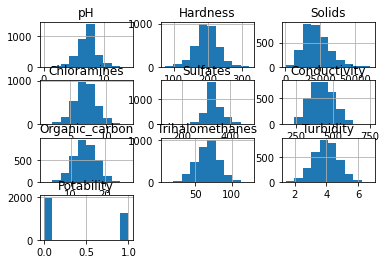

In [106]:
waterquality.hist()
plt.show()

### Chapter 4: Modelling the data <a class="anchor" id="chapter04"></a>

### 4.1. EDA <a class="anchor" id="section_4_1"></a>

Characterise the data, and show important attributes of the dataframe using descriptive statistics.

##### 4.1.1. Central tendencies <a class="anchor" id="section_4_1_1"></a>

Create a table displaying the central tendencies of the dataframe i.e. mean, standard deviation, minimum values etc.

In [107]:
waterquality.describe()

,pH,Hardness,Solids,Chloramines,Sulfates,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000
mean,7.080795,196.414973,22014.092526,7.126358,333.775777,426.205111,14.280691,66.416341,3.966786,0.390110
std,1.469956,32.776568,8768.570828,1.574445,36.142612,80.824064,3.299082,15.728077,0.780382,0.487849
min,0.000000,73.492234,320.942611,1.390871,129.000000,181.483754,2.200000,8.175876,1.450000,0.000000
25%,6.277673,176.856266,15666.690300,6.130361,317.094638,365.734414,12.065801,56.696169,3.439711,0.000000
50%,7.080795,196.967627,20927.833605,7.130299,333.775777,421.884968,14.218338,66.396293,3.955028,0.000000
75%,7.870050,216.667456,27332.762125,8.114887,350.385756,481.792305,16.553701,76.666609,4.500320,1.000000
max,14.000000,323.124000,61227.196010,13.127000,481.030642,753.342620,27.006707,124.000000,6.739000,1.000000


##### 4.1.2. Correlation plot <a class="anchor" id="section_4_1_2"></a>

Conduct a correlation plot to ensure that multicollinearity does not exist.

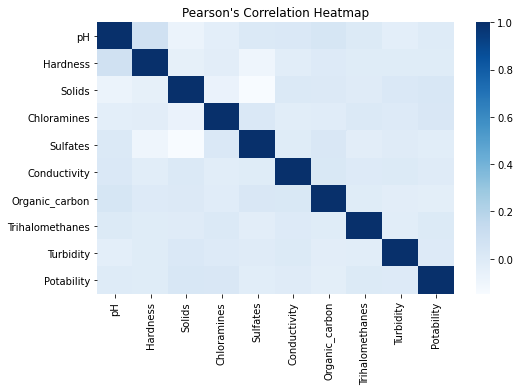

<Figure size 432x288 with 0 Axes>

In [108]:
plt.figure(figsize = (8,5))
waterquality_correlation = waterquality.corr()
axis = sns.heatmap(waterquality_correlation, cmap='Blues')
axis.set_title("Pearson's Correlation Heatmap")
plt.show()
plt.savefig('correlationmap.jpeg', bbox_inches = 'tight') # Reference: https://www.tutorialspoint.com/save-figure-as-file-from-ipython-notebook-using-matplotlib

In [109]:
X = waterquality[['pH','Hardness','Solids','Chloramines','Sulfates','Conductivity','Organic_carbon','Trihalomethanes','Turbidity']]
y = waterquality[['Potability']]

In [110]:
reg = sm.OLS(y, X).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             Potability   R-squared (uncentered):                   0.390
Model:                            OLS   Adj. R-squared (uncentered):              0.389
Method:                 Least Squares   F-statistic:                              232.4
Date:                Sun, 08 May 2022   Prob (F-statistic):                        0.00
Time:                        15:31:29   Log-Likelihood:                         -2296.1
No. Observations:                3276   AIC:                                      4610.
Df Residuals:                    3267   BIC:                                      4665.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
pH                  0.0058      0.006      1.031      0.303      -0.005       0.017
Hardness            0.0002      0.000      0.706      0.480      -0.000       0.001
Solids           2.755e-06   9.51e-07      2.898      0.004    8.91e-07    4.62e-06
Chloramines         0.0140      0.005      2.701      0.007       0.004       0.024
Sulfates            0.0002      0.000      1.225      0.221      -0.000       0.001
Conductivity     5.664e-05      0.000      0.565      0.572      -0.000       0.000
Organic_carbon     -0.0023      0.003     -0.919      0.358      -0.007       0.003
Trihalomethanes     0.0006      0.001      1.179      0.238      -0.000       0.002
Turbidity           0.0110      0.010      1.060      0.289      -0.009       0.031
==============================================================================
Omnibus:                    13598.076   Durbin-Watson:                   0.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              540.441
Skew:                           0.448   Prob(JB):                    4.41e-118
Kurtosis:                       1.223   Cond. No.                     2.89e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.89e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

No multicollinearity exists between observations - multiple models do not have to be created.

##### 4.1.3. 5 rows <a class="anchor" id="section_4_1_3"></a>

Print the first 5 rows and the last 5 rows of the dataframe.

In [111]:
waterquality.head()

,pH,Hardness,Solids,Chloramines,Sulfates,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.080795,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,333.775777,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,333.775777,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [112]:
waterquality.tail()

,pH,Hardness,Solids,Chloramines,Sulfates,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
3271,4.668102,193.681736,47580.99160,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.80216,8.061362,333.775777,392.449580,19.903225,66.396293,2.798243,1
3273,9.419510,175.762646,33155.57822,7.350233,333.775777,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.86938,6.303357,333.775777,402.883113,11.168946,77.488213,4.708658,1
3275,7.874671,195.102299,17404.17706,7.509306,333.775777,327.459761,16.140368,78.698446,2.309149,1


##### 4.1.4. Sampling the data <a class="anchor" id="section_4_1_4"></a>


Take a sample of the data from 10 random rows to understand the characteristics of the dataset.

In [113]:
waterquality.sample(10)

,pH,Hardness,Solids,Chloramines,Sulfates,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
2114,7.910641,190.427600,16461.50232,5.454476,394.305876,294.178639,17.658652,82.417022,3.886603,0
2017,8.111953,217.266472,38184.46957,7.254122,311.910224,281.069203,13.027921,78.582094,4.430750,1
2071,7.341547,187.672402,21273.45707,7.784003,333.775777,332.084293,16.842334,55.019151,4.025644,0
2173,7.080795,204.258263,26321.68919,5.937496,333.775777,487.273628,20.407809,70.340601,3.305588,0
1132,7.058183,187.947191,26608.92915,8.556396,405.403423,462.314567,18.428387,41.290330,3.613835,1
1886,4.293961,192.360737,24600.76069,8.261635,261.357041,475.876415,10.799428,53.619847,5.105121,0
3237,9.609834,227.366949,22690.04587,5.385440,314.317481,394.731563,16.988356,75.339694,4.308358,1
1468,6.279842,175.890640,11582.50525,7.059985,333.775777,430.322092,15.674785,86.760257,3.278584,0
2252,6.867522,182.672169,20247.20103,6.867073,330.805652,420.333457,17.952822,60.068800,4.837268,0
217,6.271012,213.444685,24846.14187,8.372997,333.775777,543.391744,17.916526,84.578869,5.303581,0


### 4.2. Model construction <a class="anchor" id="section_4_2"></a>

##### 4.2.1. Shuffling the data <a class="anchor" id="section_4_2_1"></a>

Here, we shuffle the data to reduce the chances of overfitting and prevent familiarity within the dataset.

In [114]:
# Reference: https://www.geeksforgeeks.org/pandas-how-to-shuffle-a-dataframe-rows/amp/

print("\n UNSHUFFLED DATAFRAME:")
print(waterquality)


 UNSHUFFLED DATAFRAME:
            pH    Hardness       Solids  Chloramines    Sulfates  \
0     7.080795  204.890456  20791.31898     7.300212  368.516441   
1     3.716080  129.422921  18630.05786     6.635246  333.775777   
2     8.099124  224.236259  19909.54173     9.275884  333.775777   
3     8.316766  214.373394  22018.41744     8.059332  356.886136   
4     9.092223  181.101509  17978.98634     6.546600  310.135738   
...        ...         ...          ...          ...         ...   
3271  4.668102  193.681736  47580.99160     7.166639  359.948574   
3272  7.808856  193.553212  17329.80216     8.061362  333.775777   
3273  9.419510  175.762646  33155.57822     7.350233  333.775777   
3274  5.126763  230.603758  11983.86938     6.303357  333.775777   
3275  7.874671  195.102299  17404.17706     7.509306  333.775777   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       564.308654       10.379783        86.990970   2.963135           0  
1    

In [115]:
waterquality = waterquality.sample(frac = 1)
print("\n SHUFFLED DATAFRAME:")
print(waterquality)


 SHUFFLED DATAFRAME:
            pH    Hardness        Solids  Chloramines    Sulfates  \
1818  7.277144  194.880861  18270.105060     6.121931  344.879754   
1681  7.460148  221.343210  25480.918410     6.926943  333.775777   
1357  7.893132  201.433250  20526.049710     5.628776  299.018236   
244   6.321259  207.257710   8532.139517     5.987877  286.489280   
2299  7.606067  248.041453  14609.976880     6.356555  322.356572   
...        ...         ...           ...          ...         ...   
24    5.400302  140.739062  17266.593420    10.056852  328.358241   
1856  7.233538  231.560832  16621.494790     6.073041  333.775777   
2861  9.318614  317.338124  24497.873940     7.597452  357.167217   
1919  8.458797  241.768340  29317.142440     5.783275  313.885548   
2120  7.080795  219.074646  31044.738180     6.772327  263.900537   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  
1818    402.664582       15.459752        76.987232   4.931354          

##### 4.2.2. Predictor and response <a class="anchor" id="section_4_2_2"></a>

The data assigned to the X and y variable to generate a model.

In [116]:
X = waterquality[['pH','Hardness','Solids','Chloramines','Sulfates','Conductivity',
                 'Organic_carbon','Trihalomethanes','Turbidity','Potability']].astype('float32')

y = waterquality[['Potability']].astype('int64')

In [117]:
print(X)

            pH    Hardness        Solids  Chloramines    Sulfates  \
1818  7.277144  194.880859  18270.105469     6.121932  344.879761   
1681  7.460148  221.343216  25480.917969     6.926943  333.775787   
1357  7.893132  201.433243  20526.048828     5.628776  299.018250   
244   6.321259  207.257706   8532.139648     5.987876  286.489288   
2299  7.606067  248.041458  14609.976562     6.356555  322.356567   
...        ...         ...           ...          ...         ...   
24    5.400302  140.739059  17266.593750    10.056852  328.358246   
1856  7.233539  231.560837  16621.494141     6.073041  333.775787   
2861  9.318614  317.338135  24497.873047     7.597452  357.167206   
1919  8.458797  241.768341  29317.142578     5.783276  313.885559   
2120  7.080794  219.074646  31044.738281     6.772327  263.900543   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  
1818    402.664581       15.459751        76.987228   4.931354         0.0  
1681    438.61962

##### 4.2.3. Test and train split <a class="anchor" id="section_4_2_3"></a>

Split the dataset into testing and training.

80% for training, and 20% for testing.

In [118]:
numbers = waterquality.iloc[:,:-1]
features = waterquality.iloc[:, -1].values

numbers = numbers.astype(np.float32)
numbers = numbers.to_numpy()
features = features.astype(np.int64)

In [119]:
X_train, X_test, y_train, y_test = train_test_split(numbers, features, test_size = 0.20, train_size = 0.80)

##### 4.2.4. Feature scaling  <a class="anchor" id="section_4_2_4"></a>

Introduce feature scaling to minimise noise in the data.

In [120]:
# Standardization since the dataset has been made to have a normal distribution

scaler = StandardScaler()
X_train_standard = scaler.fit_transform(X_train)
X_test_standard = scaler.fit_transform(X_test)

##### 4.2.5. SMOTE  <a class="anchor" id="section_4_2_5"></a>

In [121]:
X_smote_train, y_smote_train = SMOTE().fit_resample(X_train_standard, y_train)

### Chapter 5: Building a MLP<a class="anchor" id="chapter05"></a>

### 5.1. Layers and parameters <a class="anchor" id="section_5_1"></a>

We assign a value to each layer of the neural network: input, output, and the hidden layer.

In [122]:
input_layer = 9 # (number of features)
hidden_layer = 3 # (layers due to the size of the dataset)
output_layer = 2 # (number of classes)

Create a function and pass the above parameters through.

In [123]:
class MultilayerPerceptron(nn.Module):
    def __init__(self,
        input_dim = input_layer,
        hidden_dim = hidden_layer,
        output_dim= output_layer,
        dropout=0.5,
    ):
        
        super(MultilayerPerceptron, self).__init__()
        self.dropout = nn.Dropout(dropout) 
        
        self.linear1 = nn.Linear(input_layer, hidden_layer)
        self.linear2 = nn.Linear(hidden_layer, output_layer)
        
    def __getitem__(self,input_dim, hidden_dim,output_dim):
        
        return input_dim, hidden_dim, output_dim
    
    def forward(self, inputs, **kwargs):
        inputs = F.relu(self.linear1(inputs)) # pass output of hidden layer through a relu activation function
        inputs = self.dropout(inputs) # apply dropout
        inputs = F.softmax(self.linear2(inputs), dim = -1)
         
        return inputs


In [124]:
# batch_size by default is set at 128

torch.manual_seed(0)

net = NeuralNetClassifier(
    MultilayerPerceptron,
    max_epochs=30,
    lr=0.1,
    device = device,
)

### 5.2. Training results <a class="anchor" id="section_5_2"></a>

In [125]:
net.fit(X_smote_train, y_smote_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7350       0.4930        0.7251  0.2066
      2        0.7081       0.4977        0.7125  0.2009
      3        0.7011       0.5055        0.7065  0.2006
      4        0.6958       0.5149        0.7036  0.5325
      5        0.6953       0.5117        0.7009  0.2011
      6        0.6929       0.5211        0.6993  0.2654
      7        0.6896       0.5227        0.6982  0.3394
      8        0.6924       0.5243        0.6975  0.1935
      9        0.6942       0.5258        0.6972  0.2123
     10        0.6914       0.5290        0.6954  0.3318
     11        0.6901       0.5274        0.6950  0.2510
     12        0.6883       0.5290        0.6953  0.2127
     13        0.6899       0.5274        0.6950  0.2422
     14        0.6926       0.5305        0.6946  0.2435
     15        0.6855       0.5336        0.6932  0.2334
     16        0.6885       0.5

In [126]:
y_pred = net.predict(X_test_standard)

print accuracy score

In [127]:
accuracy_score(y_test, y_pred)

0.45884146341463417

the results of the training are mediocre... now we will attempt to improve the results through tuning parameters

### 5.3. Hyperparameter tuning <a class="anchor" id="section_5_3"></a>

In [128]:
class MultilayerPerceptron(nn.Module):
    def __init__(self,
        input_dim = input_layer,
        hidden_dim = hidden_layer,
        output_dim= output_layer,
        dropout=0.5,
    ):
        
        super(MultilayerPerceptron, self).__init__()
        self.dropout = nn.Dropout(dropout) 
        
        self.linear1 = nn.Linear(input_layer, hidden_layer)
        self.linear2 = nn.Linear(hidden_layer, output_layer)
        
    def __getitem__(self,input_dim, hidden_dim,output_dim):
        
        return input_dim, hidden_dim, output_dim
    
    def forward(self, inputs, **kwargs):
        inputs = F.relu(self.linear1(inputs)) # pass output of hidden layer through a relu activation function
        inputs = self.dropout(inputs) # apply dropout
        # removing the softmax activation function
        
        return inputs

In [129]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    MultilayerPerceptron,
    callbacks = [EarlyStopping()],
    criterion = nn.CrossEntropyLoss,
    device = device, 
)

parameters = {
    'lr': [0.001, 0.01, 0.1],
    'batch_size': [150,175,200],
    'optimizer': [optim.Adam, optim.SGD],
    'max_epochs': [40, 60], 
    'module__dropout': [0.5],
    'optimizer__momentum': [1.0]
}

In [130]:
cvGS = GridSearchCV(net,
                    parameters,
                    refit=True, 
                    cv=10
                    
                    
                    , 
                    scoring='accuracy', 
                    verbose=1)

cvGS.fit(X_train_standard, y_train)

print("")
print("Accuracy: {:.2f}".format(cvGS.best_score_))
print("")
print("Parameters: {}".format(cvGS.best_params_))

Fitting 10 folds for each of 36 candidates, totalling 360 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2564       0.3284        1.1862  0.1158
      2        1.2161       0.3369        1.1488  0.1281
      3        1.1904       0.4131        1.0979  0.1484
      4        1.0987       0.5021        1.0485  0.1519
      5        1.0721       0.5720        1.0230  0.1338
      6        1.0650       0.5911        1.0117  0.1379
      7        1.0238       0.5996        0.9960  0.1402
      8        1.0297       0.6186        0.9793  0.1384
      9        1.0231       0.6208        0.9626  0.1303
     10        1.0142       0.6229        0.9490  0.1398
     11        1.0049       0.6229        0.9399  0.1411
     12        1.0415       0.6144        0.9354  0.1299
     13        1.0431       0.6165        0.9346  0.1401
     14        1.0591       0.6123        0.9355  0.1422
     15        1.0661    

In [141]:
# cross validation

cvRS = RandomizedSearchCV(net, 
                           parameters, 
                           refit=False, 
                           cv=3, 
                           scoring='accuracy', 
                           verbose=0)

cvRS.fit(X_train_standard, y_train)

print("")
print("Accuracy: {:.2f}".format(cvRS.best_score_))
print("")

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1591       0.6086        0.9811  0.2006
      2        1.0358       0.5971        0.9693  0.1048
      3        1.0859       0.6057        0.9860  0.0899
      4        1.0742       0.5857        0.9925  0.0980
      5        1.0495       0.6400        0.9807  0.0918
      6        1.0538       0.6171        0.9775  0.1113
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0897       0.6029        1.0180  0.1109
      2        1.0208       0.6057        0.9643  0.1132
      3        1.0355       0.5686        0.9654  0.1125
      4        1.0545       0.5943        0.9856  0.0985
      5        1.0709       0.5886        1.0166  0.1129
      6        1.0576       0.6029        1.0145  0.2083
Stopping since valid_lo

### Chapter 6: Building a SVM<a class="anchor" id="chapter06"></a>

### 6.1. Parameters <a class="anchor" id="section_6_1"></a>

In [132]:
svm_classifier = SVC(kernel = 'linear', random_state = 0)

svm_classifier.fit(X_smote_train, y_smote_train)

y_pred_svm = svm_classifier.predict(X_test_standard)

### 6.2. Training results <a class="anchor" id="section_6_2"></a>

In [133]:
accuracy_score(y_test, y_pred_svm)

0.5

### 6.3. Hyperparameter tuning <a class="anchor" id="section_6_3"></a>

In [134]:
svm_classifier = SVC(kernel = 'rbf', random_state = 0)


svm_classifier.fit(X_train_standard, y_train)

y_pred_svm_tuned = svm_classifier.predict(X_test_standard)

In [135]:
accuracy = cross_val_score(svm_classifier, X_train_standard, y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracy.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracy.std()*100))

Accuracy: 67.29 %
Standard Deviation: 1.82 %


### Chapter 7: Final models <a class="anchor" id="chapter07"></a>


### 7.1 MLP <a class="anchor" id="section_7_1"></a>

In [136]:
class MultilayerPerceptron(nn.Module):
    def __init__(self,
        input_dim = input_layer,
        hidden_dim = hidden_layer,
        output_dim= output_layer,
        dropout=0.5,
    ):
        
        super(MultilayerPerceptron, self).__init__()
        self.dropout = nn.Dropout(dropout) 
        
        self.linear1 = nn.Linear(input_layer, hidden_layer)
        self.linear2 = nn.Linear(hidden_layer, output_layer)
        
    def __getitem__(self,input_dim, hidden_dim,output_dim):
        
        return input_dim, hidden_dim, output_dim
    
    def forward(self, inputs, **kwargs):
        inputs = F.relu(self.linear1(inputs)) # pass output of hidden layer through a relu activation function
        inputs = self.dropout(inputs) # apply dropout
        # removing the softmax activation function
        
        return inputs

torch.manual_seed(0)

net = NeuralNetClassifier(
    MultilayerPerceptron,
    callbacks = [EarlyStopping()],
    criterion = nn.CrossEntropyLoss,
    device = device, 
)

parameters = {
    'lr': [0.1],
    'batch_size': [200],
    'optimizer': [optim.SGD],
    'max_epochs': [40], 
    'module__dropout': [0.5],
    'optimizer__momentum': [1.0]
}

cvRS = RandomizedSearchCV(net, 
                           parameters, 
                           cv=3, 
                           scoring='accuracy', 
                           verbose=0)

In [137]:
cvRS.fit(X_test_standard, y_test)
MLP_pred_final = cvRS.predict(X_test_standard)

print("")
print("Accuracy: {:.2f}".format(cvRS.best_score_))

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1539       0.4205        1.1221  0.0471
      2        1.1297       0.4773        1.0827  0.0270
      3        1.0962       0.6023        1.0519  0.0156
      4        1.0995       0.6250        1.0403  0.0233
      5        1.0779       0.6250        1.0290  0.0203
      6        1.0473       0.6250        1.0179  0.0289
      7        1.0604       0.6023        1.0081  0.0290
      8        1.0370       0.6136        0.9980  0.0289
      9        1.0591       0.6250        0.9855  0.0303
     10        1.0558       0.6477        0.9725  0.0306
     11        1.0185       0.6364        0.9624  0.0227
     12        1.0257       0.6364        0.9561  0.0284
     13        1.1086       0.6364        0.9550  0.0311
     14        1.0724       0.6591        0.9567  0.0302
     15        1.0835       0.6477        0.9618  0.0225
     16        1.0209       0.6

### 7.2 SVM <a class="anchor" id="section_7_2"></a>

In [138]:
svm_classifier = SVC(kernel = 'rbf', random_state = 0)

svm_classifier.fit(X_test_standard, y_test)

accuracy = cross_val_score(svm_classifier, X_test_standard, y_test, cv = 10)
print("Accuracy: {:.2f} %".format(accuracy.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracy.std()*100))

Accuracy: 62.52 %
Standard Deviation: 2.95 %


### 7.3 Confusion matrix <a class="anchor" id="section_7_3"></a>

[[ 57 344]
 [ 11 244]]


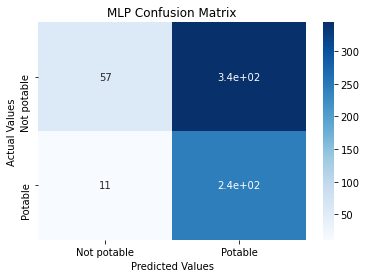

In [139]:
# create confusion matrix
# adapted from: https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/
from sklearn.metrics import confusion_matrix

cfmatrix_MLP = confusion_matrix(y_test, y_pred)
print(cfmatrix_MLP)
ax = sns.heatmap(cfmatrix_MLP, annot=True, cmap='Blues')

ax.set_title('MLP Confusion Matrix')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(['Not potable', 'Potable'])
ax.yaxis.set_ticklabels(['Not potable', 'Potable'])

plt.show()

[[214 187]
 [141 114]]


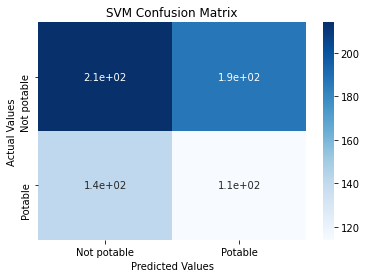

In [140]:
# create confusion matrix
# adapted from: https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/
from sklearn.metrics import confusion_matrix

cfmatrix_SVM = confusion_matrix(y_test, y_pred_svm)
print(cfmatrix_SVM)
ax = sns.heatmap(cfmatrix_SVM, annot=True, cmap='Blues')

ax.set_title('SVM Confusion Matrix')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(['Not potable', 'Potable'])
ax.yaxis.set_ticklabels(['Not potable', 'Potable'])

plt.show()